# Overview:
In this notebook, I’ll perform an initial exploratory analysis of the electric vehicle population in Washington State. The goal is to identify key trends, explore which electric vehicle models dominate different regions, and investigate potential factors driving these patterns. Throughout the analysis, I will present tables and visualizations to clearly convey the findings and provide context at each stage of the process.

# Dataset Information:
**Overview:**
This dataset contains information on Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs) currently registered with the Washington State Department of Licensing (DOL). Since the dataset is regularly updated, I extracted it in December 2024 for this analysis.

Source (data.gov): [https://catalog.data.gov/dataset/electric-vehicle-population-data/resource/fa51be35-691f-45d2-9f3e-535877965e69
](http://)


  


# Setting up Environment:

In [104]:
#importing packages
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [105]:
df = pd.read_csv("/kaggle/input/electric-vehicle-population/Electric_Vehicle_Population_Data.csv")

In [106]:
df.columns

Index(['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'Legislative District', 'DOL Vehicle ID',
       'Vehicle Location', 'Electric Utility', '2020 Census Tract'],
      dtype='object')

# Column Name Breakdown:

- **VIN (1-10):** Vehicle Identification Number
- **County:** County in Washington where the car is located
- **City:** City in Washington where the car is located
- **State:** All vehicles are in Washington
- **Postal Code:** Postal code of the vehicle's location
- **Model Year:** Year the vehicle model was manufactured
- **Make:** Car brand
- **Model:** Car model
- **Electric Vehicle Type:**  
  - Battery Electric Vehicle (BEV): Powered solely by electricity from rechargeable batteries  
  - Plug-in Hybrid Electric Vehicle (PHEV): Combines a gasoline engine with an electric battery that can be charged by plugging into an outlet
- **Clean Alternative Fuel Vehicle (CAFV) Eligibility:** Criteria a vehicle must meet to be considered a clean alternative fuel vehicle
  - Clean Alternative Fuel Vehicle Eligible  
  - Not eligible due to low battery range
  - Eligibility unknown as battery range has not been researched
- **Electric Range:** Distance an electric vehicle can travel on a single charge
- **Base MSRP:** The base price of a vehicle before add-ons or taxes
- **Legislative District:** Geographical areas in Washington
- **DOL Vehicle ID:** Unique vehicle identifier
- **Vehicle Location:** Location of vehicle in coordinates
- **Electric Utility:** Energy provider for vehicle
- **2020 Census Tract:** Demographic context for vehicle location


# Creating Scrollable Table Function for Easy Formatting and Analysis:
Retrived form: 
- Jee, K. (2023, May 16). "https://www.youtube.com/watch?v=NQQ3DRdXAXE&list=LL&index=15&t=2248s"YouTube.     

In [107]:
#function to create scrollable table using HTML package
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id> =" {table_id}" style = "height: 200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

# Displaying Dataset:

In [108]:
# Displaying first 20 rows of dataset with index starting from 1
df_display = df.head(20).reset_index(drop=True)
df_display.index = df_display.index + 1  # Set index to start from 1
html_output = create_scrollable_table(df_display, "my_table", "Electric Vehicle Data")
display(HTML(html_output))

# Number of rows in dataset
num_rows = len(df)
print(f"Number of rows:", num_rows)

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
1,5UXTA6C0XM,Kitsap,Seabeck,WA,98380.0,2021,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,30.0,0.0,35.0,267929112,POINT (-122.8728334 47.5798304),PUGET SOUND ENERGY INC,5.303509e+10
2,5YJ3E1EB1J,Kitsap,Poulsbo,WA,98370.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215.0,0.0,23.0,475911439,POINT (-122.6368884 47.7469547),PUGET SOUND ENERGY INC,5.303509e+10
3,WP0AD2A73G,Snohomish,Bothell,WA,98012.0,2016,PORSCHE,PANAMERA,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,15.0,0.0,1.0,101971278,POINT (-122.206146 47.839957),PUGET SOUND ENERGY INC,5.306105e+10
4,5YJ3E1EB5J,Kitsap,Bremerton,WA,98310.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215.0,0.0,23.0,474363746,POINT (-122.6231895 47.5930874),PUGET SOUND ENERGY INC,5.303508e+10
5,1N4AZ1CP3K,King,Redmond,WA,98052.0,2019,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,150.0,0.0,45.0,476346482,POINT (-122.13158 47.67858),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
6,3FA6P0PU5F,Snohomish,Bothell,WA,98012.0,2015,FORD,FUSION,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,19.0,0.0,21.0,9620047,POINT (-122.206146 47.839957),PUGET SOUND ENERGY INC,5.306104e+10
7,5YJYGDEEXL,King,Renton,WA,98055.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291.0,0.0,11.0,124565731,POINT (-122.2003346 47.4487206),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
8,5UXTS1C06M,King,Seattle,WA,98107.0,2021,BMW,X3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,17.0,0.0,36.0,135327104,POINT (-122.38591 47.67597),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
9,1N4AZ0CP0F,King,Bellevue,WA,98007.0,2015,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84.0,0.0,48.0,105509778,POINT (-122.1436732 47.6157551),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303302e+10
10,5YJSA1E20H,King,Seattle,WA,98125.0,2017,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210.0,0.0,46.0,348605603,POINT (-122.30253 47.72656),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10


Number of rows: 210165


# Exploring Differnt Vehicle Types and CAFV Eligibility:

In [109]:
ev_categories = df['Electric Vehicle Type'].unique()
cafv_categories = df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].unique()
df_display.index = df_display.index + 1 

print(ev_categories)
print(cafv_categories)

['Plug-in Hybrid Electric Vehicle (PHEV)' 'Battery Electric Vehicle (BEV)']
['Clean Alternative Fuel Vehicle Eligible'
 'Not eligible due to low battery range'
 'Eligibility unknown as battery range has not been researched']


# Plug in Hybrid Electric Vehicles (PHEV) vs Battery Electric Vehicles (BEV)
A Plug-in Hybrid Electric Vehicle (PHEV) combines a gasoline engine with an electric motor and can be recharged by plugging into an external power source. Examples in this dataset include the Toyota Prius Prime and Chevrolet Volt.

A Battery Electric Vehicle (BEV), or all-electric vehicle, runs entirely on electricity from a rechargeable battery, with no gas engine. The Tesla Model 3 and Nissan Leaf are common BEVs in this dataset.



# Data Cleaning + Finding Null Values:

In [110]:
# Null values in dataset
null_values = df.isnull().sum()
html_null_values = create_scrollable_table(null_values.to_frame(), "null_values", "Null Values in Dataset")
display(HTML(html_null_values))

#Removing rows with null Legislative Districts
df_cleaned = df.dropna(subset=['Legislative District'])


,0
VIN (1-10),0
County,4
City,4
State,0
Postal Code,4
Model Year,0
Make,0
Model,0
Electric Vehicle Type,0
Clean Alternative Fuel Vehicle (CAFV) Eligibility,0


# Determining the Percentage of Electric Vehicles Eligible for CAFV:

In [111]:
grouped = df.groupby(['Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility']).size().reset_index(name='Count')

# Calculate the total count for each 'Electric Vehicle Type'
grouped['Total per EV Type'] = grouped.groupby('Electric Vehicle Type')['Count'].transform('sum')

# Add a percentage column based on the count within each vehicle type group
grouped['Percentage'] = (grouped['Count'] / grouped['Total per EV Type']) * 100

#Formating: Round to two decimal places and add percent sign
grouped['Percentage'] = grouped['Percentage'].round(5)
grouped['Percentage'] = grouped['Percentage'].apply(lambda x: f"{x}%")


# Pivot the table and create a new DataFrame
percentage_df = grouped.pivot_table(
    index='Electric Vehicle Type',
    columns='Clean Alternative Fuel Vehicle (CAFV) Eligibility',
    values='Percentage',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Display the new DataFrame
percentage_table = create_scrollable_table(percentage_df, "percentage_table", "Percents")
display(HTML(percentage_table))


Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Vehicle Type,Clean Alternative Fuel Vehicle Eligible,Eligibility unknown as battery range has not been researched,Not eligible due to low battery range
0,Battery Electric Vehicle (BEV),28.32429%,71.67087%,0.00483%
1,Plug-in Hybrid Electric Vehicle (PHEV),51.87734%,0,48.12266%


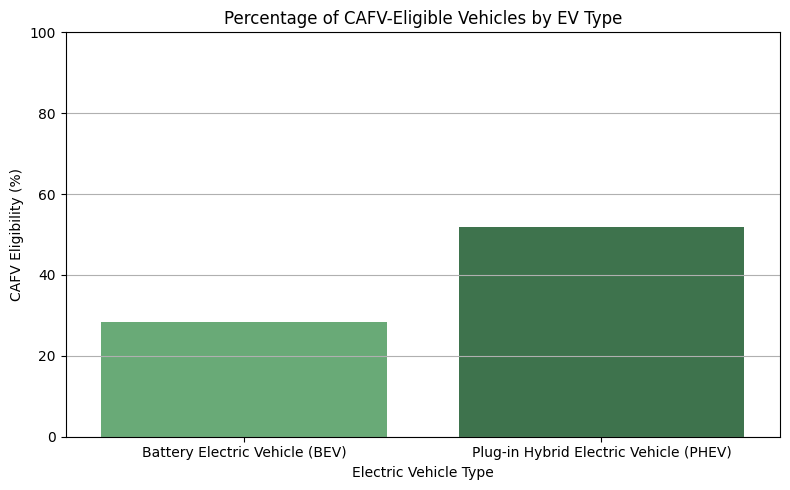

In [112]:
# Group and calculate percentages
grouped_plot = df.groupby(['Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility']) \
                 .size().reset_index(name='Count')
grouped_plot['Total per EV Type'] = grouped_plot.groupby('Electric Vehicle Type')['Count'].transform('sum')
grouped_plot['Percentage'] = (grouped_plot['Count'] / grouped_plot['Total per EV Type']) * 100

# Filter only for CAFV-eligible vehicles
eligible_plot = grouped_plot[grouped_plot['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] == 'Clean Alternative Fuel Vehicle Eligible']

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=eligible_plot,
    x='Electric Vehicle Type',
    y='Percentage',
    palette='Greens_d'
)
             
plt.title('Percentage of CAFV-Eligible Vehicles by EV Type')
plt.ylabel('CAFV Eligibility (%)')
plt.xlabel('Electric Vehicle Type')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



Plug-in Hybrid Electric Vehicles (PHEVs) have a higher percentage of CAFV eligibility compared to Battery Electric Vehicles (BEVs), likely due to their extended range capabilities qualifying them under Washington’s eligibility criteria.

# Displaying Battery Electric Vehicles (BEV) Population per District:

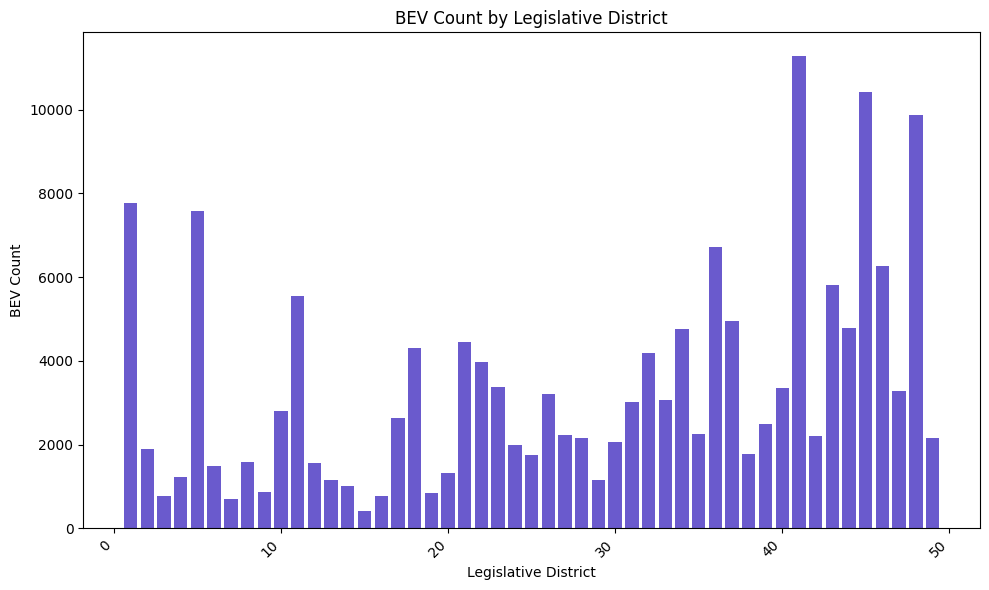

In [113]:
# Filter for Battery Electric Vehicles (BEV) 
bev_df = df.loc[df['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)']

# Group by Legislative District and count the number of BEVs
bev_count = bev_df.groupby('Legislative District').size().reset_index(name='BEV Count')

# Sort by count 
bev_count = bev_count.sort_values(by='BEV Count', ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(bev_count['Legislative District'], bev_count['BEV Count'], color='slateblue')
plt.xlabel('Legislative District')
plt.ylabel('BEV Count')
plt.title('BEV Count by Legislative District')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

# Displaying Hybrid Electric Vehicles (PHEV) Population per District:

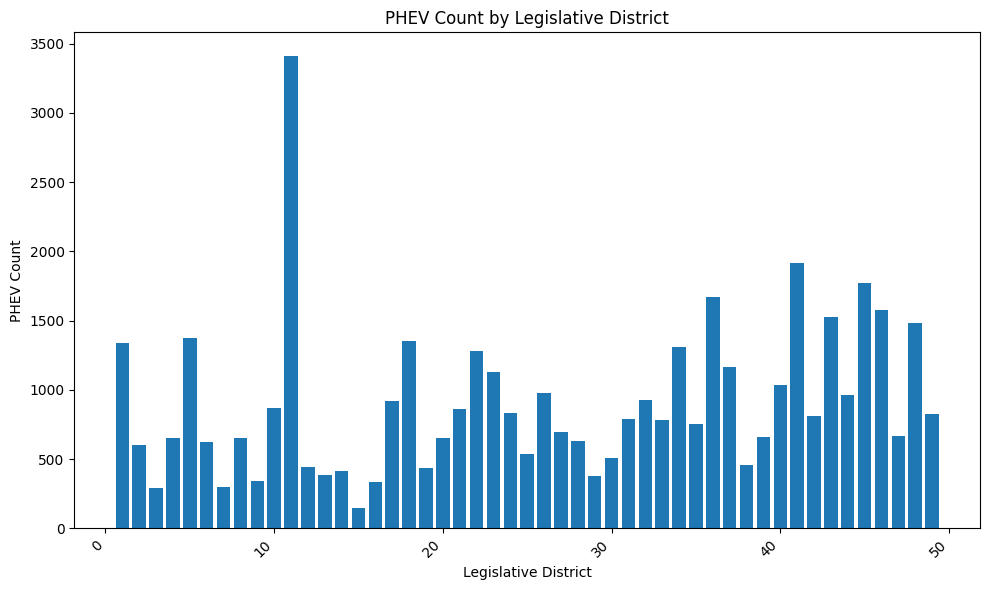

In [114]:
# Filter for Plug-in Hybrid Electric Vehicles (PHEV)
phev_df = df.loc[df['Electric Vehicle Type'] == 'Plug-in Hybrid Electric Vehicle (PHEV)']

# Group by Legislative District and count the number of PHEVs
phev_count = phev_df.groupby('Legislative District').size().reset_index(name='PHEV Count')

# Sort by count
phev_count = phev_count.sort_values(by='PHEV Count', ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(phev_count['Legislative District'], phev_count['PHEV Count'], color='#1f77b4')
plt.xlabel('Legislative District')
plt.ylabel('PHEV Count')
plt.title('PHEV Count by Legislative District')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Creating Groupped Bar Chart:

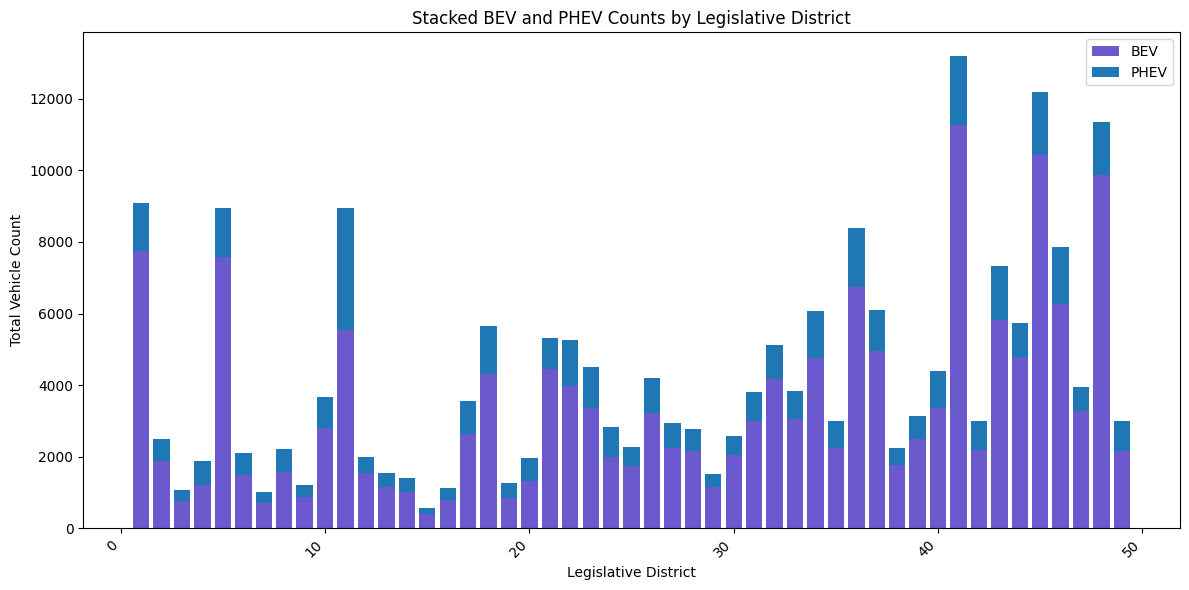

In [115]:
bev_df = df[df['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)']
phev_df = df[df['Electric Vehicle Type'] == 'Plug-in Hybrid Electric Vehicle (PHEV)']

# Count by Legislative District
bev_counts = bev_df.groupby('Legislative District').size().reset_index(name='BEV Count')
phev_counts = phev_df.groupby('Legislative District').size().reset_index(name='PHEV Count')

# Merge the two count DataFrames on Legislative District
merged_counts = pd.merge(bev_counts, phev_counts, on='Legislative District', how='outer').fillna(0)

# Sort districts for consistent plotting
merged_counts = merged_counts.sort_values('Legislative District')

# X-axis positions
districts = merged_counts['Legislative District']
x = np.arange(len(districts))
width = 0.35

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
plt.bar(districts, merged_counts['BEV Count'], label='BEV', color='slateblue')
plt.bar(districts, merged_counts['PHEV Count'], bottom=merged_counts['BEV Count'], label='PHEV', color='#1f77b4')

plt.xlabel('Legislative District')
plt.ylabel('Total Vehicle Count')
plt.title('Stacked BEV and PHEV Counts by Legislative District')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Greater BEV Population in Each District
Overall, **BEVs make up a larger share of the electric vehicles across all legislative districts**. Let’s break down which models are contributing to that total.

In [116]:
# Filter for BEVs and create combined Make_Model
bev_df = df[df['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)'].copy()
bev_df['Make_Model'] = bev_df['Make'] + ' ' + bev_df['Model']

# Count vehicles per Make_Model per district
model_counts = bev_df.groupby(['Legislative District', 'Make_Model']).size().reset_index(name='Count')

# For each district, get only the top model (highest count)
top_model_per_district = model_counts.sort_values(['Legislative District', 'Count'], ascending=[True, False]) \
    .groupby('Legislative District').head(1).reset_index(drop=True)

# Sort for display
sorted_top_models = top_model_per_district.sort_values(['Legislative District'])

# Create and display the scrollable table
scrollable_table = create_scrollable_table(
    sorted_top_models, 
    'top_model_per_district_table', 
    'Top BEV Model by Legislative District'
)

display(HTML(scrollable_table))

# Print summary
print('Summary:')
print('Most frequent top model:', sorted_top_models['Make_Model'].mode().iloc[0])
print('Number of districts where Tesla Model Y is the top model:',
      len(sorted_top_models[sorted_top_models['Make_Model'] == 'TESLA MODEL Y']))

,Legislative District,Make_Model,Count
0,1.0,TESLA MODEL Y,2769
1,2.0,TESLA MODEL Y,472
2,3.0,TESLA MODEL Y,166
3,4.0,TESLA MODEL Y,320
4,5.0,TESLA MODEL Y,2398
5,6.0,TESLA MODEL Y,393
6,7.0,TESLA MODEL Y,194
7,8.0,TESLA MODEL Y,374
8,9.0,TESLA MODEL 3,220
9,10.0,TESLA MODEL Y,586


Summary:
Most frequent top model: TESLA MODEL Y
Number of districts where Tesla Model Y is the top model: 42


# Tesla's Prevalence Across Districts
Tesla models dominate the electric vehicle landscape, being the most common BEV in 48 out of 49 districts. Among these, the Tesla Model Y is the top model in 42 districts.

Below is a chart that further illustrates this, with the Tesla Model Y and Model 3 being the most common vehicles across the districts:

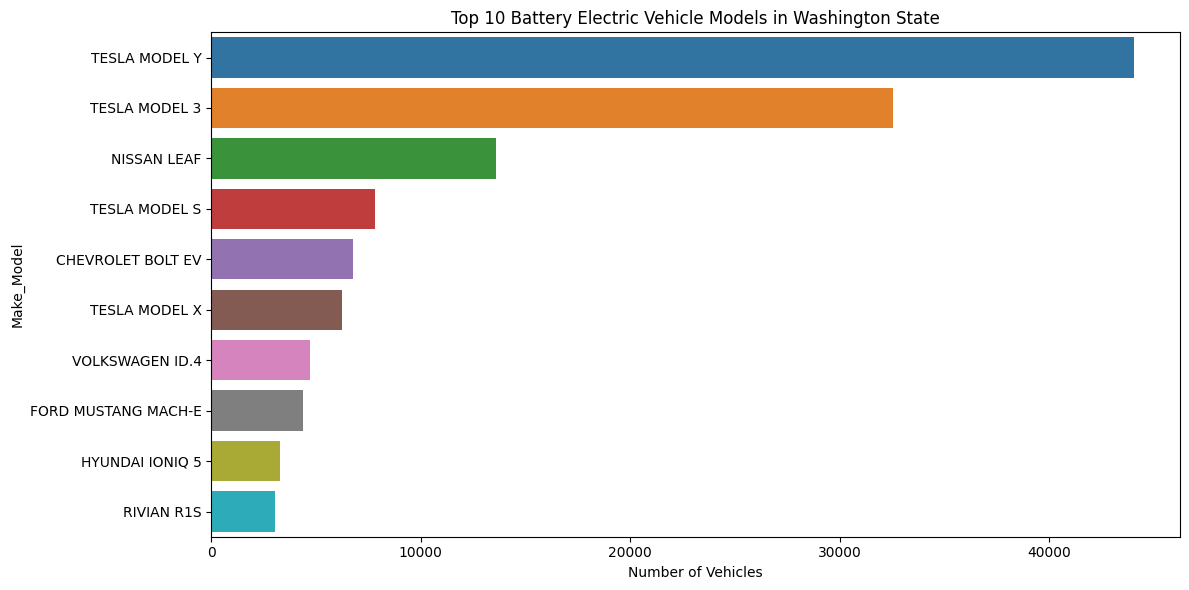

Top 10 BEV Models and their counts:
Make_Model
TESLA MODEL Y          44038
TESLA MODEL 3          32520
NISSAN LEAF            13606
TESLA MODEL S           7795
CHEVROLET BOLT EV       6780
TESLA MODEL X           6239
VOLKSWAGEN ID.4         4716
FORD MUSTANG MACH-E     4363
HYUNDAI IONIQ 5         3265
RIVIAN R1S              3059
Name: count, dtype: int64


In [117]:
# Filter for BEVs
bev_df = df[df['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)'].copy()

# Combine Make and Model
bev_df['Make_Model'] = bev_df['Make'] + ' ' + bev_df['Model']

# Get top 10 models overall
top_models = bev_df['Make_Model'].value_counts().head(10)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_models.values, y=top_models.index)
plt.title('Top 10 Battery Electric Vehicle Models in Washington State')
plt.xlabel('Number of Vehicles')
plt.tight_layout()
plt.show()

# Print the exact counts
print("Top 10 BEV Models and their counts:")
print(top_models)


# Importance of Tesla's Dominance:
Tesla's dominance in Washington State's legislative districts reflects key market trends:

**Market Influence:**

- Tesla's strong brand and robust charging network give it a competitive edge, driving wider EV adoption.

**Policy & Infrastructure Implications:**

- Governments can learn from Tesla’s success to improve charging infrastructure and optimize incentives.

**Equity Considerations:**

- The prevalence of expensive Teslas highlights potential barriers to EV access, underscoring the need for affordable options and more diverse EV choices.

# Exploring Tesla Dominance in High-BEV Districts:
I wanted to take a closer look at equity issues related to EV access in Washington. Teslas make up a large portion of BEVs, especially in districts with higher BEV counts, which might point to affordability barriers or gaps in charging infrastructure.

If one high-cost brand dominates the market, it raises questions about how accessible EVs really are. To dig into this, we can compare the percentage of Teslas in the top five BEV districts to those in the bottom five.

In [118]:
# Filter for Battery Electric Vehicles
bevs = df[df['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)'].copy()
bevs['Is_Tesla'] = bevs['Make'].str.upper() == 'TESLA'

# Count BEVs by Legislative District
bev_counts = bevs['Legislative District'].value_counts().sort_index()

# Get Top 5 and Bottom 5 districts based on BEV count
top5_districts = bev_counts.sort_values(ascending=False).head().index
bottom5_districts = bev_counts.sort_values().head().index

# Compute % Tesla in each district
tesla_percentages = (
    bevs.groupby(['Legislative District', 'Is_Tesla'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={True: 'Tesla', False: 'Non-Tesla'})
)
tesla_percentages['Total'] = tesla_percentages['Tesla'] + tesla_percentages['Non-Tesla']
tesla_percentages['% Tesla'] = (tesla_percentages['Tesla'] / tesla_percentages['Total'] * 100).round(2)

# Reset index so Legislative District is a column
tesla_percentages = tesla_percentages.reset_index()

# Filter and sort for top 5 and bottom 5 districts by BEV count (instead of district)
top5_tesla = tesla_percentages[tesla_percentages['Legislative District'].isin(top5_districts)].sort_values(by='Total', ascending=False).reset_index(drop=True)
bottom5_tesla = tesla_percentages[tesla_percentages['Legislative District'].isin(bottom5_districts)].sort_values(by='Total', ascending=True).reset_index(drop=True)

# Set index to start at 1
top5_tesla.index = top5_tesla.index + 1
bottom5_tesla.index = bottom5_tesla.index + 1

# Create scrollable tables
top5_tesla_table = create_scrollable_table(top5_tesla[['Legislative District', 'Tesla', 'Non-Tesla', 'Total', '% Tesla']], 'top5_tesla_table', 'Top 5 BEV Districts: % Teslas')
bottom5_tesla_table = create_scrollable_table(bottom5_tesla[['Legislative District', 'Tesla', 'Non-Tesla', 'Total', '% Tesla']], 'bottom5_tesla_table', 'Bottom 5 BEV Districts: % Teslas')

# Display both
display(HTML(top5_tesla_table))
display(HTML(bottom5_tesla_table))





Is_Tesla,Legislative District,Tesla,Non-Tesla,Total,% Tesla
1,41.0,7843,3437,11280,69.53
2,45.0,6789,3632,10421,65.15
3,48.0,6521,3342,9863,66.12
4,1.0,4972,2789,7761,64.06
5,5.0,4594,2985,7579,60.61


Is_Tesla,Legislative District,Tesla,Non-Tesla,Total,% Tesla
1,15.0,269,146,415,64.82
2,7.0,387,321,708,54.66
3,3.0,326,445,771,42.28
4,16.0,420,360,780,53.85
5,19.0,379,466,845,44.85


When we look at the districts with the most BEVs, about **65.09%** of them are Teslas on average. In the districts with the fewest BEVs, that average drops to **52.09%**. This may suggest that Teslas make up a bigger share of the EV population where there are already more EVs overall, which could point to differences in access or affordability across districts.

We can figure out if there's relationship using a scatter plot with a least squares regression line to show the correlation between each district's BEV percentage and corresponding Tesla percentage:

# Creating Scatterplot:

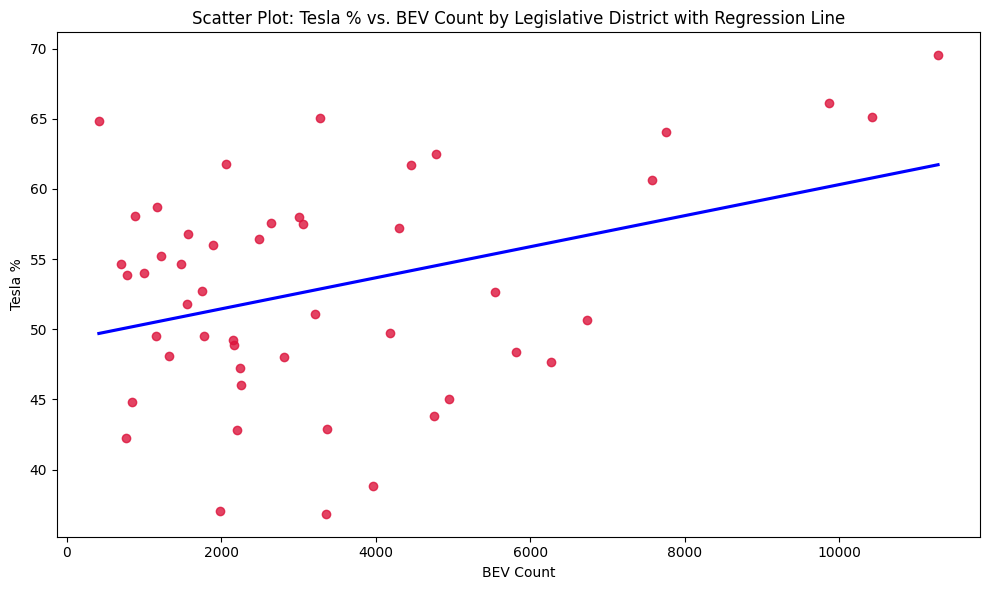

In [119]:
# Filter for Battery Electric Vehicles (BEVs)
bevs = df[df['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)']

# Calculate BEV count by Legislative District
bev_counts = bevs['Legislative District'].value_counts().sort_index()

# Calculate the number of Teslas in each district
tesla_counts = bevs[bevs['Make'] == 'TESLA'].groupby('Legislative District').size()

# Calculate Tesla % for each district
tesla_percentage = (tesla_counts / bev_counts) * 100

# Create a DataFrame to combine BEV Count and Tesla %
scatter_data = pd.DataFrame({
    'BEV Count': bev_counts,
    'Tesla %': tesla_percentage
}).fillna(0)  # Fill NaN values with 0 for districts without Teslas

# Plot the scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='BEV Count', y='Tesla %', data=scatter_data, scatter_kws={'color': 'crimson'}, line_kws={'color': 'blue'}, ci=None)
plt.title('Scatter Plot: Tesla % vs. BEV Count by Legislative District with Regression Line')
plt.xlabel('BEV Count')
plt.ylabel('Tesla %')
plt.tight_layout()
plt.show()




# Calculating Summary Statisitcs:

In [120]:
# Perform Pearson correlation to see the relationship between BEV count and Tesla %
correlation, _ = stats.pearsonr(scatter_data['BEV Count'], scatter_data['Tesla %'])
print(f"Pearson correlation coefficient: {correlation:.2f}")

# Perform linear regression to get additional statistics (slope, intercept, R-squared, p-value)
slope, intercept, r_value, p_value, std_err = stats.linregress(scatter_data['BEV Count'], scatter_data['Tesla %'])
print(f"Linear regression result:")
print(f"Slope: {slope:.2f}")
print(f"Intercept: {intercept:.2f}")
print(f"R-squared: {r_value**2:.2f}")
print(f"P-value: {p_value:.4f}")


Pearson correlation coefficient: 0.37
Linear regression result:
Slope: 0.00
Intercept: 49.25
R-squared: 0.13
P-value: 0.0098


# Statsitcal Analysis Summary:
* The Pearson **correlation coefficient of 0.37 indicates a weak to moderate positive correlation between the BEV count and Tesla percentage across districts.** While this suggests that as the number of BEVs increases in a district, there may be a slight increase in the percentage of Teslas, the strength of the relationship is not particularly strong.
* **The linear regression results show that the slope is 0.00, meaning that there is no significant increase in Tesla percentage as BEV count increases**, suggesting a flat relationship between these two variables. However, the intercept of 49.25 indicates that, when the BEV count is zero, the Tesla percentage is approximately 49.25%, which might reflect the average Tesla presence in lower-BEV districts.
* **The R-squared value of 0.13 suggests that only 13% of the variation in Tesla percentage can be explained by the BEV count.** This indicates that while there is some relationship, much of the variation in Tesla percentage is due to factors other than BEV count.
* **Lastly, the p-value of 0.0098 is statistically significant (less than 0.05), indicating that the observed relationship is unlikely to be due to random chance. **Despite the weak correlation and low R-squared, the results suggest that there is a statistically significant but modest relationship between BEV count and Tesla percentage in these districts.



# Analysis of BEV Count and Tesla Percentage Relationship
While the relationship between BEV count and Tesla percentage is weak and only explains a small portion of the variation, the statistical significance (p-value < 0.05) supports that the observed trend is not due to chance. Further investigation into other factors influencing Tesla percentage, such as income levels, charging infrastructure, and vehicle pricing, would be beneficial. However, exploring these aspects would require additional datasets and analysis steps beyond the scope of exploratory data analysis, as they involve external factors that are not included in the current dataset. These additional insights could provide a deeper understanding of why Teslas are more common in certain districts and help inform future policy decisions.


# Conclusion
This exploratory data analysis of Washington State's electric vehicle population reveals several key insights:

- Tesla dominates the BEV market across legislative districts, with Tesla Models leading 48 out of 49 districts and the Model Y leading in 42 out of 49 districts.

- The distribution of electric vehicles varies significantly by region, indicating regional trends in BEV adoption.

Further exploration could include:

- Charging Infrastructure: Understanding the role of charging stations in influencing BEV adoption across regions.

- Demographic and Socioeconomic Factors: Examining how income levels and access to incentives affect the adoption of different BEV models.

- Environmental Impact: Analyzing the environmental benefits of BEVs in different regions to understand how EV adoption contributes to sustainability.

Key findings include:

- Data Cleaning and Preprocessing: Ensuring the dataset was ready for meaningful analysis.

- Exploratory Data Analysis: Identifying significant trends in BEV distribution across legislative districts.

- Data Visualization: Using various visual tools to highlight patterns and distributions in the data.

- Geographic Data Handling: Mapping BEV distribution to identify regional trends.

- Statistical Analysis: Performing correlation and regression to explore the relationship between BEV count and Tesla adoption in each Washington district.

A weak positive correlation between BEV count and Tesla percentage was observed and is not strong enough to explain a significant portion of the variation. However, the statistical significance (p-value < 0.05) suggests that the trend is unlikely to be due to chance. Further analysis is needed to investigate other factors, such as local incentives and infrastructure, that might help explain Tesla’s dominance in high-population districts.

Overall, Washington State shows clear trends in BEV adoption, with Tesla leading the market. A more detailed analysis could help uncover whether factors such as the district itself play a role in driving these patterns, along with other potential influences.


**Tools used:** Python, Pandas, Matplotlib, Seaborn, Scipy